In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import precision_recall_fscore_support
import os
import random
import copy
import json
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## If using google collab, run once then comment out once google drive is connected

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Variables to change

In [ ]:
# Environment variables (doesn't need changing)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# directories ("experiment" only needs to be changed)
path = '/content/gdrive/MyDrive/'
classes = np.sort(os.listdir(path + 'data/val'))
experiment = 'run1' # folder where models from each epoch will be saved per experiment 
if 'models' not in os.listdir(path):
  os.mkdir(path + 'models')
if experiment not in os.listdir(path + 'models'):
  os.mkdir(path + 'models/' + experiment)

# training (change as needed)
balance_classes = True
pretrain = True
freeze = True
class_weighted_loss = False
class_weights = torch.Tensor([4.0, 4.0, 3.0, 4.0, 3.0, 1.0, 4.0]).to(device)
model_input_size = 224
epochs = 20 # number of times entire train set is trained on
lr = 0.001
gamma = 0.9
batch_size = 32


# Augmentation variables (change as needed)
brightness = 0.1
contrast = 0.1
saturation = 0.1
hue = 0.1
prob_horz_flip = 0.5
prob_vert_flip = 0.5
rotation = 360

In [ ]:
# helper functions
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

## If using a custom CNN, modify everything below `super().__init__()`

In [ ]:
# custom CNN (this one is AlexNet, so not custom)
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 7),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## Train
def train(net, criterion, optimizer, scheduler, trainloader, valloader, classes, path, device, train_dataset, val_dataset, epochs, 
          full_train):
  lowest_val_loss = np.inf
  epoch_high = 0
  loss_values, val_loss_values = [], []
  for epoch in range(0, epochs):  # loop over the dataset multiple times

      train_loss = 0.0
      all_outputs, all_labels = [], []
      net.train()
      for data in trainloader:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # add loss
          train_loss += loss.item() * inputs.size(0)

          all_outputs += torch.max(outputs.data, 1)[1].tolist()
          all_labels += labels.tolist()
      scheduler.step()
      loss_values.append(train_loss / len(train_dataset))
      # ppv, sens, _, _ = precision_recall_fscore_support(all_labels, all_outputs, average=None, labels=list(np.sort(pd.Series(all_labels).unique())))
      # ppv_dict = {class_name:np.round(p, 3) for class_name, p in zip(classes, ppv)}
      # sens_dict = {class_name:np.round(s, 3) for class_name, s in zip(classes, sens)}
      # print('PPV:', ppv_dict)
      # print('Sensitivity:', sens_dict)
      
      if full_train:
        valid_loss = 0.0
        net.eval()     # Optional when not using Model Specific layer
        all_outputs, all_labels = [], []
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss = loss.item() * inputs.size(0)
            all_outputs += torch.max(outputs.data, 1)[1].tolist()
            all_labels += labels.tolist()
        val_loss_values.append(valid_loss / len(val_dataset))
        ppv, sens, f1, _ = precision_recall_fscore_support(all_labels, all_outputs, average=None, labels=list(np.sort(pd.Series(all_labels).unique())))
        ppv_dict = {class_name:np.round(p, 3) for class_name, p in zip(classes, ppv)}
        sens_dict = {class_name:np.round(s, 3) for class_name, s in zip(classes, sens)}
        print('PPV:', ppv_dict)
        print('Sensitivity:', sens_dict)  
      torch.save(net.state_dict(), path + 'models/' + 'run1' + '/saved_model' + str(epoch) + '.pth')
  if not full_train:
    valid_loss = 0.0
    net.eval()     # Optional when not using Model Specific layer
    all_outputs, all_labels = [], []
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        valid_loss = loss.item() * inputs.size(0)
        all_outputs += torch.max(outputs.data, 1)[1].tolist()
        all_labels += labels.tolist()
    val_loss_values.append(valid_loss / len(val_dataset))
    ppv, sens, f1, _ = precision_recall_fscore_support(all_labels, all_outputs, average=None, labels=list(np.sort(pd.Series(all_labels).unique())))
  return val_loss_values, loss_values
      
      # if valid_loss < lowest_val_loss:
      #     epoch_high = epoch 
      #     lowest_val_loss = valid_loss

      # print(f'Epoch {epoch} \t\t Training Loss: {np.round(train_loss / len(trainloader), 3)} \t\t Validation Loss: {np.round(valid_loss / len(valloader), 3)}')
      

  # print('Finished Training')

## Model, loss function, and optimizer can all be changed

In [ ]:
# truth = []
# batches = []
# for data, labels in trainloader:
#   truth += labels.tolist()
#   batches.append(pd.Series(labels).value_counts().sort_index().values)
# print('total:', pd.Series(truth).value_counts().sort_index())


In [ ]:
# Setup data loaders
def get_data_loaders(model_input_size, rotation, color_jitter, prob_flip, balance_classes, pretrain, batch_size, path):
  if pretrain:
    train_transform = transforms.Compose([transforms.Resize(model_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                        [0.229, 0.224, 0.225]),
                                    transforms.RandomRotation(rotation),
                                    transforms.ColorJitter(color_jitter, color_jitter, color_jitter, color_jitter),
                                    transforms.RandomHorizontalFlip(p=prob_flip),
                                    transforms.RandomVerticalFlip(p=prob_flip)]
                                    )
    val_transform = transforms.Compose([transforms.Resize(model_input_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
  else:
    train_transform = transforms.Compose([transforms.Resize(model_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], 
                                                        [0.5, 0.5, 0.5]),
                                    transforms.RandomRotation(rotation),
                                    transforms.ColorJitter(color_jitter, color_jitter, color_jitter, color_jitter),
                                    transforms.RandomHorizontalFlip(p=prob_flip),
                                    transforms.RandomVerticalFlip(p=prob_flip)]
                                    )
    val_transform = transforms.Compose([transforms.Resize(model_input_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], 
                                                        [0.5, 0.5, 0.5])])
    
  train_dataset = datasets.ImageFolder(path + 'data/train', transform=train_transform)
  if balance_classes:
    weights = make_weights_for_balanced_classes(train_dataset.imgs, 7)
    weights = torch.DoubleTensor(weights)                                       
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    trainloader = torch.utils.data.DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
  else:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)


  val_dataset = datasets.ImageFolder(path + 'data/val', transform=val_transform)
  valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True, num_workers=2)

  return trainloader, valloader, train_dataset, val_dataset

In [ ]:
### Model setup

# choose a model
net = torchvision.models.mobilenet_v2(pretrained=pretrain)

if pretrain:
  if freeze:
      for param in net.parameters():
          param.requires_grad = False
  num_feats = net.classifier[-1].in_features
  bias = not net.classifier[-1].bias == None
  net.classifier[-1] = nn.Linear(in_features=num_feats, out_features=7, bias=bias)
net_test = copy.deepcopy(net)
net_test = net_test.to(device)
net = net.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
# # HPs
# batch_sizes = [16, 32]
# color_jitters = [0.0, 0.05, 0.1]
# rotations = [90, 360]
# lrs = [0.0001, 0.001]
# prob_flips = [0.0, 0.5]
# f1s = []
full_train = True
color_jitter = 0.1
prob_flip = 0.5
# epochs = 3
# i = 0
# for batch_size in batch_sizes:
#   for color_jitter in color_jitters:
#     for rotation in rotations:
#       for lr in lrs:
#         for prob_flip in prob_flips:
trainloader, valloader, train_dataset, val_dataset = get_data_loaders(model_input_size, rotation, color_jitter, prob_flip, 
                                                                      balance_classes, pretrain, batch_size, path)
# choose a loss function
if class_weighted_loss:
  criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
else:
  criterion = nn.CrossEntropyLoss().to(device)

# choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
train_loss, val_loss = train(net, criterion, optimizer, scheduler, trainloader, valloader, classes, path, device, 
                                  train_dataset, val_dataset, epochs, full_train)
#           details = {'batch_size': batch_size, 'color_jitter': color_jitter, 'rotation': rotation, 'lr': lr, 'prob_flip': prob_flip}
#           f1s.append({'model': i, 'params': details, 'f1_macro': f1})
#           print('grid ' + str(i) + ' of 53')
#           i += 1
# f1s_list = [i['f1_macro'] for i in f1s]
# top_3_f1s = sorted(range(len(f1s_list)), key=lambda i: f1s_list[i])[-3:]
# with open(path + 'models/models.txt', 'w') as convert_file:
#     for i in top_3_f1s:
#         convert_file.write(json.dumps(f1s[i]))

PPV: {'akiec': 0.0, 'bcc': 0.0, 'bkl': 0.213, 'df': 0.008, 'mel': 0.0, 'nv': 0.872, 'vasc': 0.017}
Sensitivity: {'akiec': 0.0, 'bcc': 0.0, 'bkl': 0.486, 'df': 0.357, 'mel': 0.0, 'nv': 0.237, 'vasc': 0.4}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV: {'akiec': 0.0, 'bcc': 0.385, 'bkl': 0.247, 'df': 0.013, 'mel': 0.052, 'nv': 0.939, 'vasc': 0.016}
Sensitivity: {'akiec': 0.0, 'bcc': 0.061, 'bkl': 0.336, 'df': 0.571, 'mel': 0.144, 'nv': 0.173, 'vasc': 0.2}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV: {'akiec': 1.0, 'bcc': 0.346, 'bkl': 0.187, 'df': 0.012, 'mel': 0.027, 'nv': 0.905, 'vasc': 0.016}
Sensitivity: {'akiec': 0.02, 'bcc': 0.22, 'bkl': 0.407, 'df': 0.429, 'mel': 0.018, 'nv': 0.339, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.286, 'bkl': 0.196, 'df': 0.011, 'mel': 0.02, 'nv': 0.854, 'vasc': 0.071}
Sensitivity: {'akiec': 0.02, 'bcc': 0.171, 'bkl': 0.386, 'df': 0.214, 'mel': 0.009, 'nv': 0.644, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.287, 'bkl': 0.226, 'df': 0.012, 'mel': 0.059, 'nv': 0.883, 'vasc': 0.091}
Sensitivity: {'akiec': 0.02, 'bcc': 0.305, 'bkl': 0.414, 'df': 0.214, 'mel': 0.153, 'nv': 0.465, 'vasc': 0.2}
PPV: {'akiec': 0.0, 'bcc': 0.272, 'bkl': 0.127, 'df': 0.008, 'mel': 0.0, 'nv': 0.855, 'vasc': 0.182}
Sensitivity: {'akiec': 0.0, 'bcc': 0.268, 'bkl': 0.536, 'df': 0.071, 'mel': 0.0, 'nv': 0.533, 'vasc': 0.2}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV: {'akiec': 0.0, 'bcc': 0.344, 'bkl': 0.143, 'df': 0.01, 'mel': 0.0, 'nv': 0.868, 'vasc': 0.091}
Sensitivity: {'akiec': 0.0, 'bcc': 0.134, 'bkl': 0.421, 'df': 0.286, 'mel': 0.0, 'nv': 0.482, 'vasc': 0.2}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV: {'akiec': 1.0, 'bcc': 0.304, 'bkl': 0.127, 'df': 0.016, 'mel': 0.0, 'nv': 0.886, 'vasc': 0.143}
Sensitivity: {'akiec': 0.02, 'bcc': 0.207, 'bkl': 0.443, 'df': 0.5, 'mel': 0.0, 'nv': 0.386, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.293, 'bkl': 0.13, 'df': 0.007, 'mel': 0.0, 'nv': 0.837, 'vasc': 0.034}
Sensitivity: {'akiec': 0.02, 'bcc': 0.207, 'bkl': 0.443, 'df': 0.071, 'mel': 0.0, 'nv': 0.569, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.304, 'bkl': 0.144, 'df': 0.009, 'mel': 0.056, 'nv': 0.847, 'vasc': 0.074}
Sensitivity: {'akiec': 0.02, 'bcc': 0.171, 'bkl': 0.343, 'df': 0.214, 'mel': 0.063, 'nv': 0.489, 'vasc': 0.2}
PPV: {'akiec': 0.0, 'bcc': 0.27, 'bkl': 0.223, 'df': 0.013, 'mel': 0.069, 'nv': 0.804, 'vasc': 0.133}
Sensitivity: {'akiec': 0.0, 'bcc': 0.207, 'bkl': 0.193, 'df': 0.214, 'mel': 0.09, 'nv': 0.675, 'vasc': 0.2}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV: {'akiec': 0.5, 'bcc': 0.306, 'bkl': 0.116, 'df': 0.011, 'mel': 0.083, 'nv': 0.846, 'vasc': 0.111}
Sensitivity: {'akiec': 0.02, 'bcc': 0.183, 'bkl': 0.457, 'df': 0.214, 'mel': 0.009, 'nv': 0.459, 'vasc': 0.2}
PPV: {'akiec': 0.5, 'bcc': 0.3, 'bkl': 0.124, 'df': 0.012, 'mel': 0.041, 'nv': 0.841, 'vasc': 0.182}
Sensitivity: {'akiec': 0.02, 'bcc': 0.22, 'bkl': 0.421, 'df': 0.214, 'mel': 0.018, 'nv': 0.496, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.279, 'bkl': 0.166, 'df': 0.015, 'mel': 0.039, 'nv': 0.809, 'vasc': 0.143}
Sensitivity: {'akiec': 0.02, 'bcc': 0.207, 'bkl': 0.379, 'df': 0.143, 'mel': 0.027, 'nv': 0.656, 'vasc': 0.2}
PPV: {'akiec': 0.5, 'bcc': 0.348, 'bkl': 0.12, 'df': 0.01, 'mel': 0.05, 'nv': 0.843, 'vasc': 0.222}
Sensitivity: {'akiec': 0.02, 'bcc': 0.195, 'bkl': 0.407, 'df': 0.214, 'mel': 0.027, 'nv': 0.462, 'vasc': 0.2}
PPV: {'akiec': 1.0, 'bcc': 0.288, 'bkl': 0.11, 'df': 0.01, 'mel': 0.038, 'nv': 0.853, 'vasc': 0.08}
Sensitivity: {'akiec': 0.02, 'bcc': 0.232, 'bkl': 0.4,

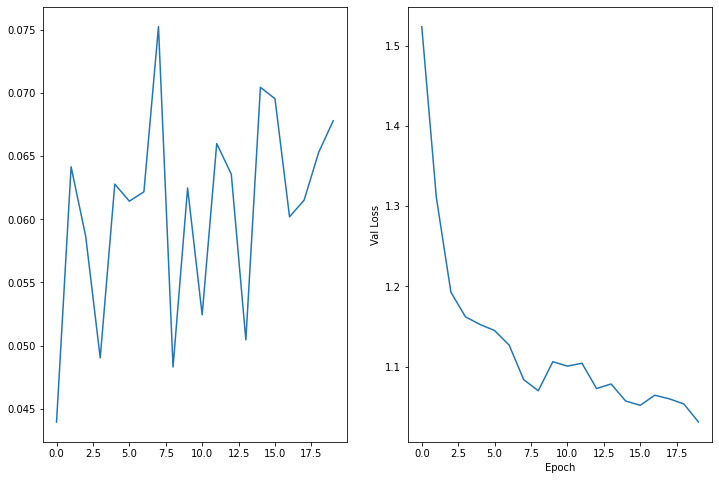

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, '-')
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.plot(range(epochs), val_loss, '-')
plt.xlabel('Epoch')
plt.ylabel('Val Loss');

In [ ]:
# Test a model on val set
model_path = path + 'models/' + experiment + '/saved_model' + str(epoch_high) + '.pth'
net_test.load_state_dict(torch.load(model_path))
net_test.eval()
preds, truth = [], []
with torch.no_grad():
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds += predicted.tolist()
        truth += labels.tolist()
ppv, sens, _, _ = precision_recall_fscore_support(truth, preds, average=None, labels=list(np.sort(pd.Series(truth).unique())))
ppv_dict = {class_name:np.round(p, 3) for class_name, p in zip(classes, ppv)}
sens_dict = {class_name:np.round(s, 3) for class_name, s in zip(classes, sens)}
print('PPV:', ppv_dict)
print('Sensitivity:', sens_dict)

In [ ]:
epoch_high

NameError: ignored

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
[0.02919708 0.12690355 0.48063781 0.36363636 0.00815217 0.44540407
 0.26229508]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
[0.02040816 0.19512195 0.52142857 0.14285714 0.00900901 0.43058161
 0.10526316]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
[0.02380952 0.14285714 0.4527027  0.5        0.00740741 0.44700461
 0.14285714]


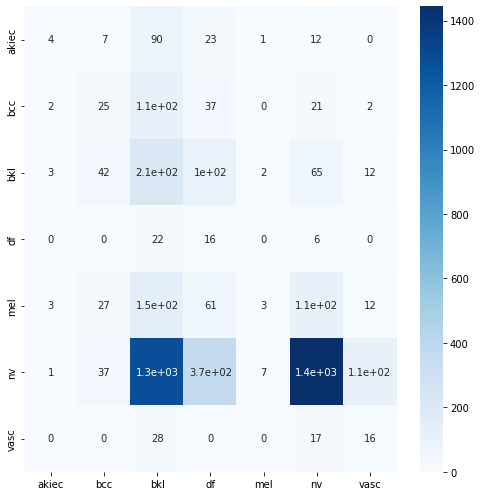

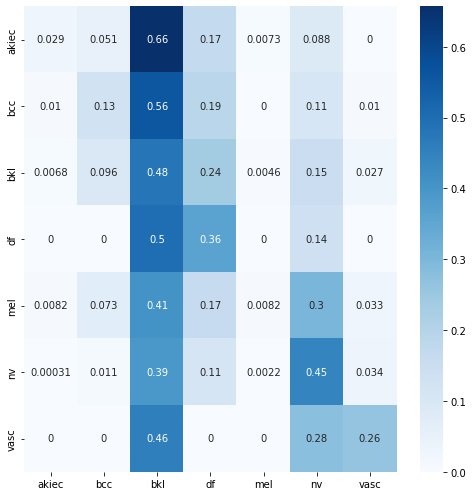

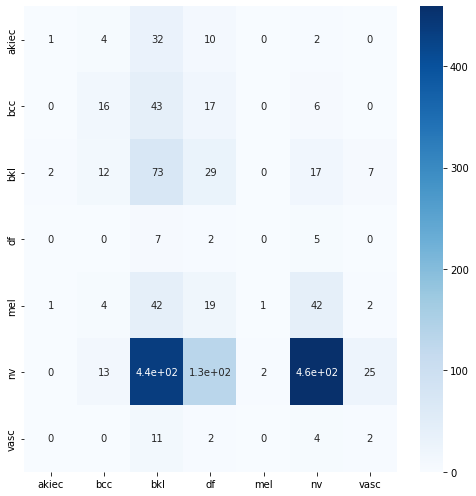

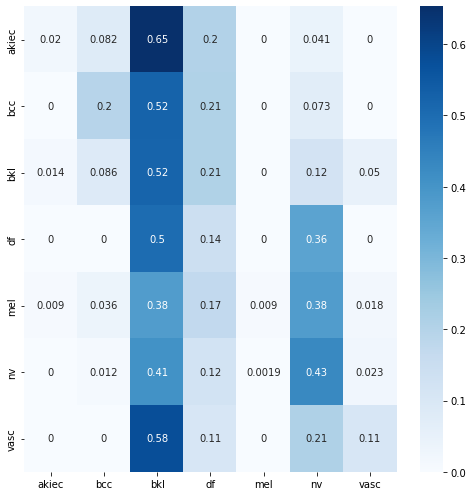

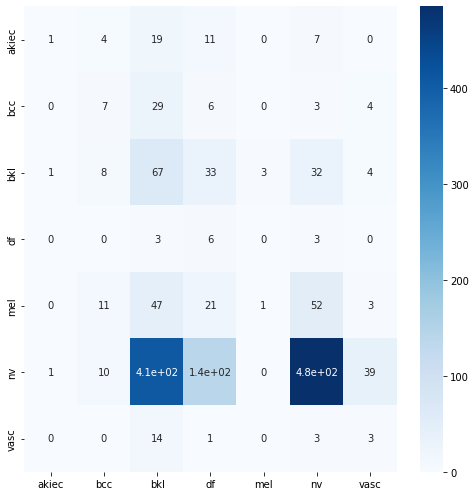

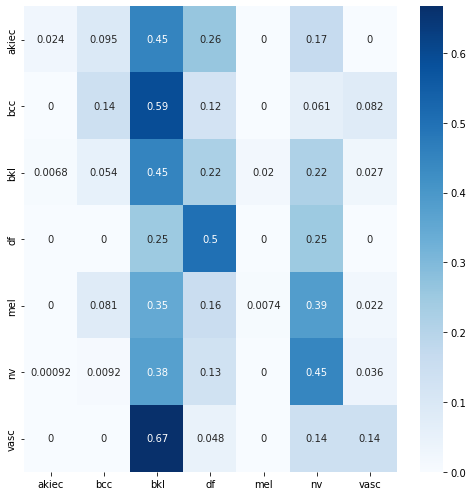

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
path = '/content/gdrive/MyDrive/'
classes = np.sort(os.listdir(path + 'data/val'))
net_test = torchvision.models.mobilenet_v2(pretrained=True)
num_feats = net_test.classifier[-1].in_features
bias = not net_test.classifier[-1].bias == None
net_test.classifier[-1] = nn.Linear(in_features=num_feats, out_features=7, bias=bias)
model_path = path + 'models/' + 'run1' + '/saved_model' + str(19) + '.pth'
net_test.load_state_dict(torch.load(model_path))
net_test = net_test.to(device)
net_test.eval()

transform = transforms.Compose([transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(path + 'data/' + x, transform=transform) for x in ['train', 'val', 'test']}
# Create training and validation dataloaders

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
all_gt, all_preds = [], []
image_pred = [{}, {}, {}]
with torch.no_grad():
    for j, group in enumerate(['train', 'val', 'test']):
      preds, gt = [], []
      for i, (inputs, labels) in enumerate(dataloaders_dict[group]):
          test_input = inputs.to(device)
          test_label = labels.to(device)
          test_output = net_test(test_input)
          _, test_pred = torch.max(test_output, 1)
          sample_fname, label = dataloaders_dict[group].dataset.samples[i]
          img = sample_fname.split('/')[-1]
          image_pred[j][img] = test_pred.item()
          preds.append(test_pred.item())
          gt.append(labels.item())
          if i%100 == 0: print(i)
      all_gt.append(gt)
      all_preds.append(preds)
      ppv, sens, _, _ = precision_recall_fscore_support(gt, preds, average=None, labels=list(np.sort(pd.Series(gt).unique())))
      print(sens)
      conf_mat_norm = sklearn.metrics.confusion_matrix(gt, preds, labels=list(np.sort(pd.Series(gt).unique())), normalize='true')
      conf_mat = sklearn.metrics.confusion_matrix(gt, preds, labels=list(np.sort(pd.Series(gt).unique())), normalize=None)
      plt.figure(figsize=(7, 7))
      sns.heatmap(conf_mat, cmap='Blues', xticklabels=list(classes), yticklabels=list(classes), annot=True)
      plt.tight_layout()
      plt.savefig(path + 'data/' + group + '.jpg')
      plt.figure(figsize=(7, 7))
      sns.heatmap(conf_mat_norm, cmap='Blues', xticklabels=list(classes), yticklabels=list(classes), annot=True)
      plt.tight_layout()
      plt.savefig(path + 'data/' + group + '_norm.jpg')

In [ ]:
val_df = pd.DataFrame.from_dict(image_pred[0], orient='index').rename(columns={0:'prediction'})
test_df = pd.DataFrame.from_dict(image_pred[1], orient='index').rename(columns={0:'prediction'})

In [ ]:
val_df.to_csv(path + 'data/val.csv')
test_df.to_csv(path + 'data/test.csv')

In [ ]:
list(reversed(list(classes)))

['vasc', 'nv', 'mel', 'df', 'bkl', 'bcc', 'akiec']

(array([  3.,  40.,   0., 587.,   0., 220.,   4.,   0., 585.,  53.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

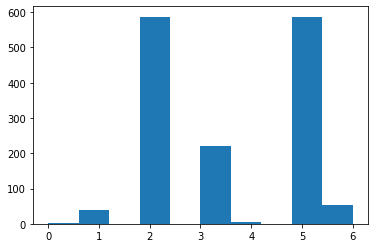

In [ ]:
plt.hist(preds)

(array([  42.,   49.,    0.,  148.,    0.,   12.,  135.,    0., 1085.,
          21.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

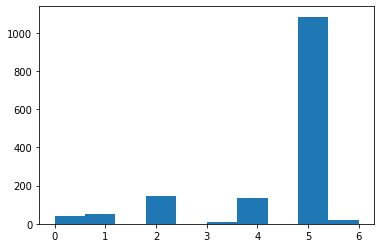

In [ ]:
plt.hist(gt)

In [ ]:
ppv, sens, _, _ = precision_recall_fscore_support(gt, preds, average=None, labels=list(np.sort(pd.Series(gt).unique())))

In [ ]:
ppv

array([0.33333333, 0.175     , 0.11413969, 0.02727273, 0.25      ,
       0.82905983, 0.05660377])

In [ ]:
sens

array([0.02380952, 0.14285714, 0.4527027 , 0.5       , 0.00740741,
       0.44700461, 0.14285714])

In [ ]:
dataset = datasets.ImageFolder(path + 'data/' + 'val')
print(dataset.class_to_idx)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [4]:
np.sum(np.array(all_preds[-1]) == np.array(all_gt[-1])) / len(all_gt[-1])

0.3820375335120643